# Option Pricing: Black-Scholes, Heston, and Merton
## Overall Objective: Understand and compare three fundamental option pricing models.

<span style="color:gray; opacity: 0.5;">**1. Black-Scholes:** The benchmark model assuming constant volatility.</span>  
    <span style="color:gray; opacity: 0.5;">_Provides a great baseline and is computationally efficient, but assumes constant $\sigma$ which is unrealistic for modern markets._</span>

<span style="color:gray; opacity: 0.5;">**2. Merton Jump:** Adds "jumps" to the asset price to model market shocks.</span>  
    <span style="color:gray; opacity: 0.5;">_Captures "Fat Tails" and sudden crashes via Poisson jumps._</span>

    
<div style="border-left: 4px solid #2196F3; padding-left: 15px;">

**3. Heston: Adds stochastic volatility (volatility clustering and mean reversion).**   
_Captures the "Smirk" or "Skew" via stochastic vol—essential for pricing OTM puts accurately._
</div>




# Model 3: The Heston Stochastic Volatility Model
## Objective: Capturing the "Leverage Effect" and Volatility Clustering

The Black-Scholes model assumes volatility is a constant number. However, looking at the VIX, we know that volatility is highly dynamic. It clusters (high vol periods follow high vol periods) and it mean-reverts (eventually calms down).

Steven Heston (1993) solved this by modeling the asset price and its variance as two correlated, random processes:

### The Mathematical Intuition
The Heston model is governed by two Stochastic Differential Equations (SDEs):

1. **The Asset Price Process:** $$\frac{dS_t}{S_t} = \mu dt + \sqrt{v_t} dW_t^S$$
2. **The Variance Process (CIR Process):** $$dv_t = \kappa(\theta - v_t)dt + \xi \sqrt{v_t} dW_t^v$$

**The Parameters:**
* $v_0$: Initial Variance.
* $\theta$ (Theta): Long-term average variance.
* $\kappa$ (Kappa): The rate of mean reversion (how fast vol returns to $\theta$).
* $\xi$ (Xi): Volatility of Volatility (determines the convexity of the smile).
* $\rho$ (Rho): The Correlation between the two Brownian motions ($dW_t^S$ and $dW_t^v$). 

**The Magic of $\rho$:** In equity markets like the S&P 500, $\rho$ is heavily negative (around -0.7). When the market crashes, volatility explodes. This negative correlation is what mathematically drags the left side of the volatility smile upward, creating the "Skew."

### Pricing via Characteristic Functions

Since there is no simple closed-form solution like Black-Scholes, we use the Fourier Transform method. The price is an integral of the Characteristic Function $\phi$.

**Important Note on Stability (Albrecher et al.):**

Standard implementations of the Heston characteristic function often suffer from "branch cut" discontinuities, leading to numerical explosions (sawtooth graphs). We use the "Albrecher" representation to ensure the characteristic function remains continuous and stable.

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy.integrate import quad
import seaborn as sns

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Global Parameters (Toggles)
S0 = 100.0    # Spot Price
K_list = np.linspace(80, 120, 50) # Range of Strikes for plotting
T = 1.0       # Time to Maturity (1 year)
r = 0.05      # Risk-free rate
q = 0.0       # Dividend yield

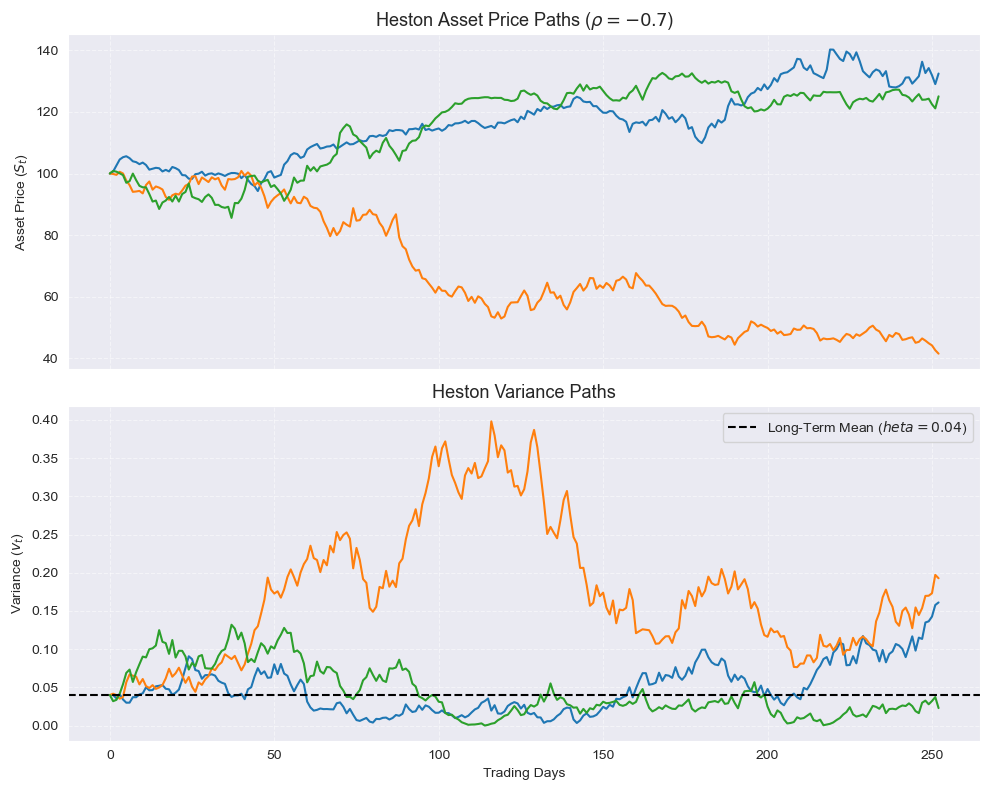

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Heston Simulation Parameters ---
S0 = 100.0      # Initial Stock Price
v0 = 0.04       # Initial Variance (20% Volatility)
kappa = 3.0     # Speed of mean reversion
theta = 0.04    # Long-term variance
xi = 0.6        # Volatility of Volatility
rho = -0.7      # Negative correlation (Equity market characteristic)
r = 0.05
T = 1.0         # 1 Year
steps = 252     # Trading days
dt = T / steps
n_paths = 3     # Just a few paths to keep the visual clean

np.random.seed(42)

# 1. Generate Correlated Brownian Motions
# We use Cholesky decomposition to correlate the random numbers
Z1 = np.random.standard_normal((steps, n_paths))
Z2 = np.random.standard_normal((steps, n_paths))
Z_S = Z1
Z_v = rho * Z1 + np.sqrt(1 - rho**2) * Z2

# 2. Setup Path Arrays
S = np.zeros((steps + 1, n_paths))
v = np.zeros((steps + 1, n_paths))
S[0] = S0
v[0] = v0

# 3. Euler-Maruyama Integration 
for t in range(1, steps + 1):
    # Variance Process (with Full Truncation to prevent negative variance)
    v_prev = np.maximum(v[t-1], 0)
    dv = kappa * (theta - v_prev) * dt + xi * np.sqrt(v_prev) * np.sqrt(dt) * Z_v[t-1]
    v[t] = np.maximum(v_prev + dv, 0)
    
    # Asset Price Process
    dS = r * S[t-1] * dt + np.sqrt(v_prev) * S[t-1] * np.sqrt(dt) * Z_S[t-1]
    S[t] = S[t-1] + dS

# --- Plotting the Correlated Paths ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Asset Price
ax1.plot(S, linewidth=1.5)
ax1.set_title(rf"Heston Asset Price Paths ($\rho = {rho}$)", fontsize=13)
ax1.set_ylabel("Asset Price ($S_t$)")
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot Variance
ax2.plot(v, linewidth=1.5)
ax2.axhline(theta, color='black', linestyle='--', label=f'Long-Term Mean ($\theta={theta}$)')
ax2.set_title("Heston Variance Paths", fontsize=13)
ax2.set_xlabel("Trading Days")
ax2.set_ylabel("Variance ($v_t$)")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Calculating Theoretical Smiles across different markets...


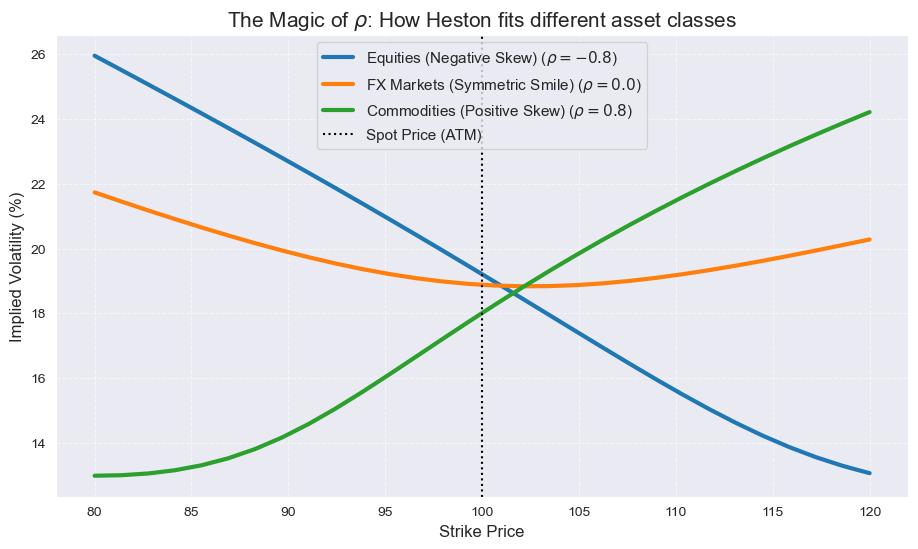

In [5]:
import warnings
from quant_math_engine import heston_call_price, implied_volatility

# --- Define Base Parameters ---
S0_t = 100.0
T_t = 0.5   # 6 months
r_t = 0.05
q_t = 0.0
strikes = np.linspace(80, 120, 30)

v0_t, kappa_t, theta_t, xi_t = 0.04, 2.0, 0.04, 0.5

# We will test 3 different correlation environments
correlations = {
    "Equities (Negative Skew)": -0.8,
    "FX Markets (Symmetric Smile)": 0.0,
    "Commodities (Positive Skew)": 0.8
}

print("Calculating Theoretical Smiles across different markets...")

plt.figure(figsize=(11, 6))

for label, rho_test in correlations.items():
    ivs = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for K in strikes:
            # Get Heston Price
            price = heston_call_price(S0_t, K, T_t, r_t, q_t, v0_t, kappa_t, theta_t, xi_t, rho_test)
            # Convert to IV
            iv = implied_volatility(price, S0_t, K, T_t, r_t, q_t)
            ivs.append(iv * 100)
            
    # Plot the specific market shape
    plt.plot(strikes, ivs, linewidth=3, label=f"{label} ($\\rho = {rho_test}$)")

# Formatting
plt.axvline(S0_t, color='black', linestyle=':', label='Spot Price (ATM)')
plt.title("The Magic of $\\rho$: How Heston fits different asset classes", fontsize=15)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()